# Short Lab 3 : Proximal/cyclic/greedy coordinate descent

#### Authors: M. Massias, P. Ablin

## Aim

The aim of this material is to code 
- cyclic and greedy coordinate descent for ordinary least squares (OLS)
- proximal gradient descent for sparse Logistic regression

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 11th of november at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 5 novembre 2017**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "Yu"
ln1 = "Xiang"
fn2 = "Jean"
ln2 = "Babin"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab3", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab3_xiang_yu_and_babin_jean.ipynb


In [2]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

In [3]:
# the usual functions:

from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu(coefs, n_samples=1000, corr=0.5, for_logreg=False):
    n_features = len(coefs)
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    b = A.dot(coefs) + randn(n_samples)
    if for_logreg:
        b = np.sign(b)
    return A, b

## Part 1: Ordinary Least Squares


Let $A \in \mathbb{R}^{n \times p}$, $y \in \mathbb{R}^n$.
We want to use coordinate descent to solve:
    $$\hat w \in  \mathrm{arg \, min \,} \frac 12 \Vert Aw - b \Vert ^2 $$

We ask you to code:
- cyclic coordinate descent: at iteration $t$, update feature $j = t \mod p$
- greedy coordinate descent: at iteration $t$, update feature having the largest partial gradient in magnitude, ie $j = \mathrm{arg\, max \,}_{i} \vert \nabla_i f(w_t) \vert$.


**WARNING**: You must do this in a clever way, ie such that $p$ updates cost the same as one update of GD.

In [4]:
n_features = 100
np.random.seed(1970)

coefs = np.random.randn(n_features)

A, b = simu(coefs, n_samples=1000, for_logreg=False)

In [5]:
def cyclic_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    
    w = np.zeros(n_features)
    residuals = b - A.dot(w)
    
    # TODO
    lips_const = np.linalg.norm(A, axis = 0) ** 2
    # END TODO
    
    for t in range(n_iter):
        j = t % n_features
        # TODO
        old_w_j = w[j].copy()
        w[j] += A[:, j].T.dot(residuals) / lips_const[j]
        # update residuals:
        residuals += A[:, j].dot(old_w_j - w[j])
        # END TODO
        
        if t % n_features == 0:
            all_objs.append((residuals ** 2).sum() / 2.)
    return w, np.array(all_objs)



def greedy_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    
    w = np.zeros(n_features)
    
    gradient = A.T.dot(A.dot(w) - b)
    gram = A.T.dot(A)  # you will need this to keep the gradient up to date
    
    # TODO
    lips_const = np.linalg.norm(A, axis = 0) ** 2
    # END TODO 
    
    for t in range(n_iter):
        # TODO
        # choose feature j to update: 
        j = np.argmax(np.abs(gradient))
        old_w_j = w[j].copy()
        w[j] -= gradient[j] / lips_const[j]
        # update gradient:
        gradient += gram[j] * (w[j] - old_w_j)
        # END TODO
        if t % n_features == 0:
            all_objs.append(0.5 * np.linalg.norm(A.dot(w) - b) ** 2)
    
    return w, np.array(all_objs)

<b>Compute a precise minimum with your favorite solver</b>

In [6]:
#@njit    
def grad_i(i, x, A, b):
    """Gradient with respect to a sample"""  
    return  A.T[i,:]  * (A.dot(x) - b)

#@njit
def grad(x, A, b):
    """Full gradient"""
    return  A.T.dot((A.dot(x) - b))

def loss(x, A, b):
    return norm(A.dot(x) - b) ** 2 / 2

In [7]:
# choose BFGS as my preferable minimizer
from scipy.optimize import fmin_l_bfgs_b
w_init = np.zeros(n_features)
w_min, f_min, _ = fmin_l_bfgs_b(loss, w_init, grad, args=(A, b), pgtol=1e-30, factr=1e-30)
print("Precise minimum : ", f_min)

Precise minimum :  466.3849765337659


<b>Compare the performance of cyclic and greedy CD</b>

In [8]:
w_cyclic, f_c = cyclic_cd(A, b, 1000)

In [9]:
w_greedy, f_g = greedy_cd(A, b, 1000)

In [10]:
f_min_cyclic = [norm(f - f_min) for f in f_c]
f_min_greedy = [norm(f - f_min) for f in f_g]

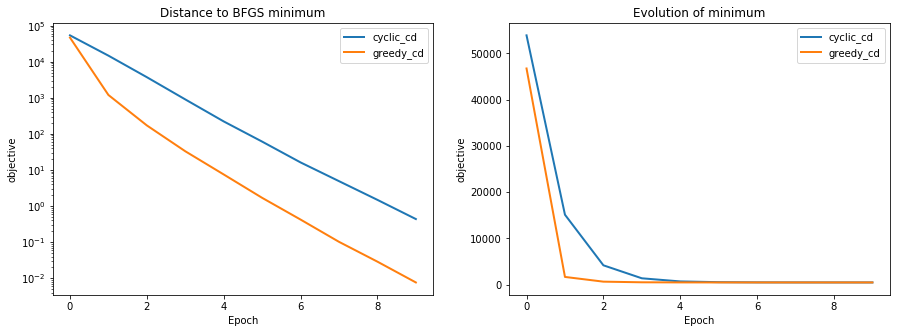

In [11]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.semilogy(f_min_cyclic, lw=2, label="cyclic_cd")
plt.semilogy(f_min_greedy, lw=2, label="greedy_cd")
plt.title("Distance to BFGS minimum")
plt.xlabel("Epoch")
plt.ylabel("objective")
plt.legend(loc=1)
plt.subplot(1, 2, 2)
plt.plot(f_c, lw=2, label="cyclic_cd")
plt.plot(f_g, lw=2, label="greedy_cd")
plt.title("Evolution of minimum")
plt.xlabel("Epoch")
plt.ylabel("objective")
plt.legend(loc=1)
plt.show()

- Both Greedy and Cyclic CD converge to the same minimum as BFGS
- It takes more iterations for cyclic CD than greedy to reach the precise minimum. Indeed Cyclic CD update coordinate one after the other (it cylcles through coordinates) while Greedy picks coordinates intelligently based on the gradient. The greedy algorithm takes the gradient that has the largest magnitude.
- For CCD, a single sweep through all coordinates takes time linear in the number of parameters.
- For GCD, we have a sublinear convergence rate. The number of iterations avoids costly dependence on the number of parameters.

<b>Could you use greedy CD for unregularized logistic regression? for OLS, but with 100,000 features? Explain your answers.</b>

- No, since it is not strongly convex and the algorithm could possibly find the local minimum for each coordinate so it does not move anymore whereas we are still far from the global minimum.

- For OLS, but with 100,000 features:  theoretically yes. But since $L(\Delta f) = \lambda_{max}{A^TA}$, and when number of features is too big, it may happen that $f(x^{(t)})- f(x^*) << \frac{L(\Delta f)}{2} ||x^{(t)}- x^*||^2$, i.e. the model may converges very slowing to the solution, therefore practically infeasible.

## Part 2: Sparse Logistic regression

### An important result

Remember: we are solving 
$$\hat w \in \mathrm{arg \, min} \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1$$
1) Show that:
$$ \lambda \geq \lambda_{max} \implies \hat w = 0$$
where $\lambda_{max} := \frac 12 \Vert X^\top y \Vert_{\infty}$.


You will need the following beautiful result: for any $w =(w_1, \dots, w_p) \in \mathbb{R}^p$, the subdifferential of the L1 norm at $w$ is:

$$\partial \Vert \cdot \Vert_1 (w) = \partial \vert \cdot \vert_1 (w_1)  \times \dots \times \partial \vert \cdot \vert_1 (w_p) $$
where $\times$ is the Cartesian product between sets,
and $$ \partial \vert \cdot \vert_1 (w_1) = 
\begin{cases} &w_j / |w_j| &\mathrm{if} \quad w_j \neq 0, 
         \\ & [-1, 1] &\mathrm{otherwise.} 
\end{cases}
$$


(it should now be easy to find $\partial \Vert \cdot \Vert_1 (\mathbf{0}_p)$)

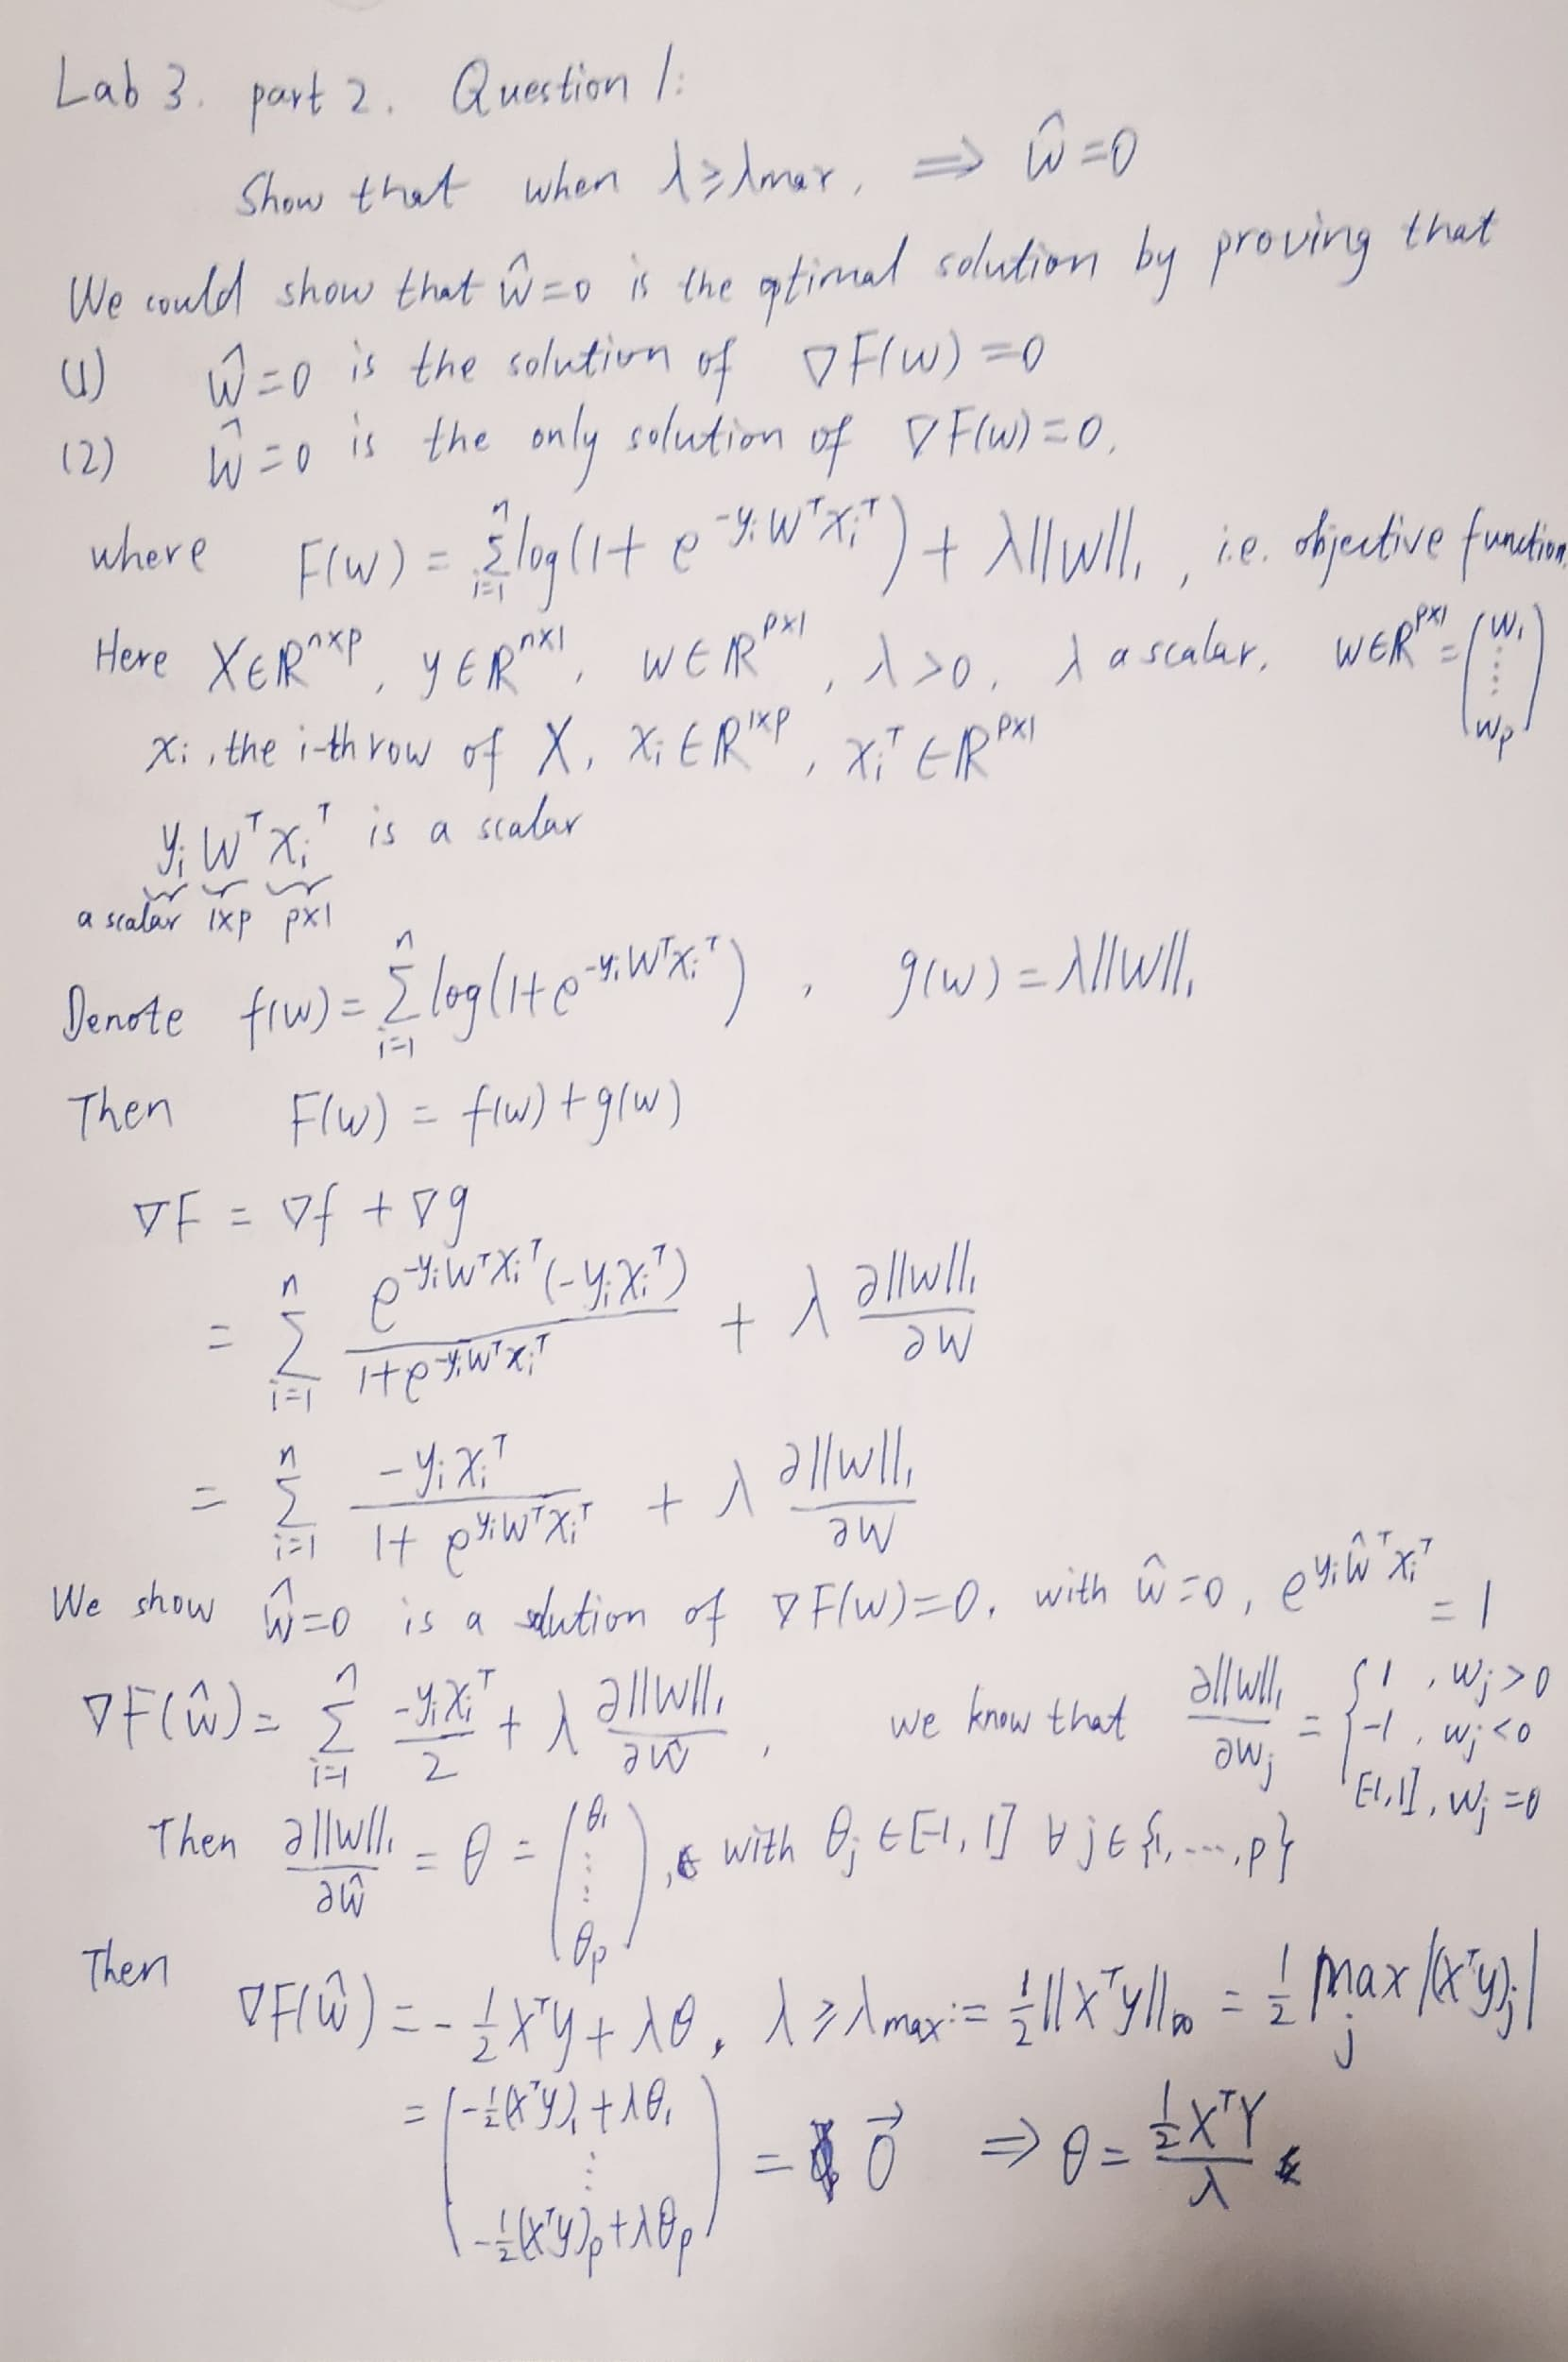

In [12]:
from IPython.display import Image
Image("page1.jpg")

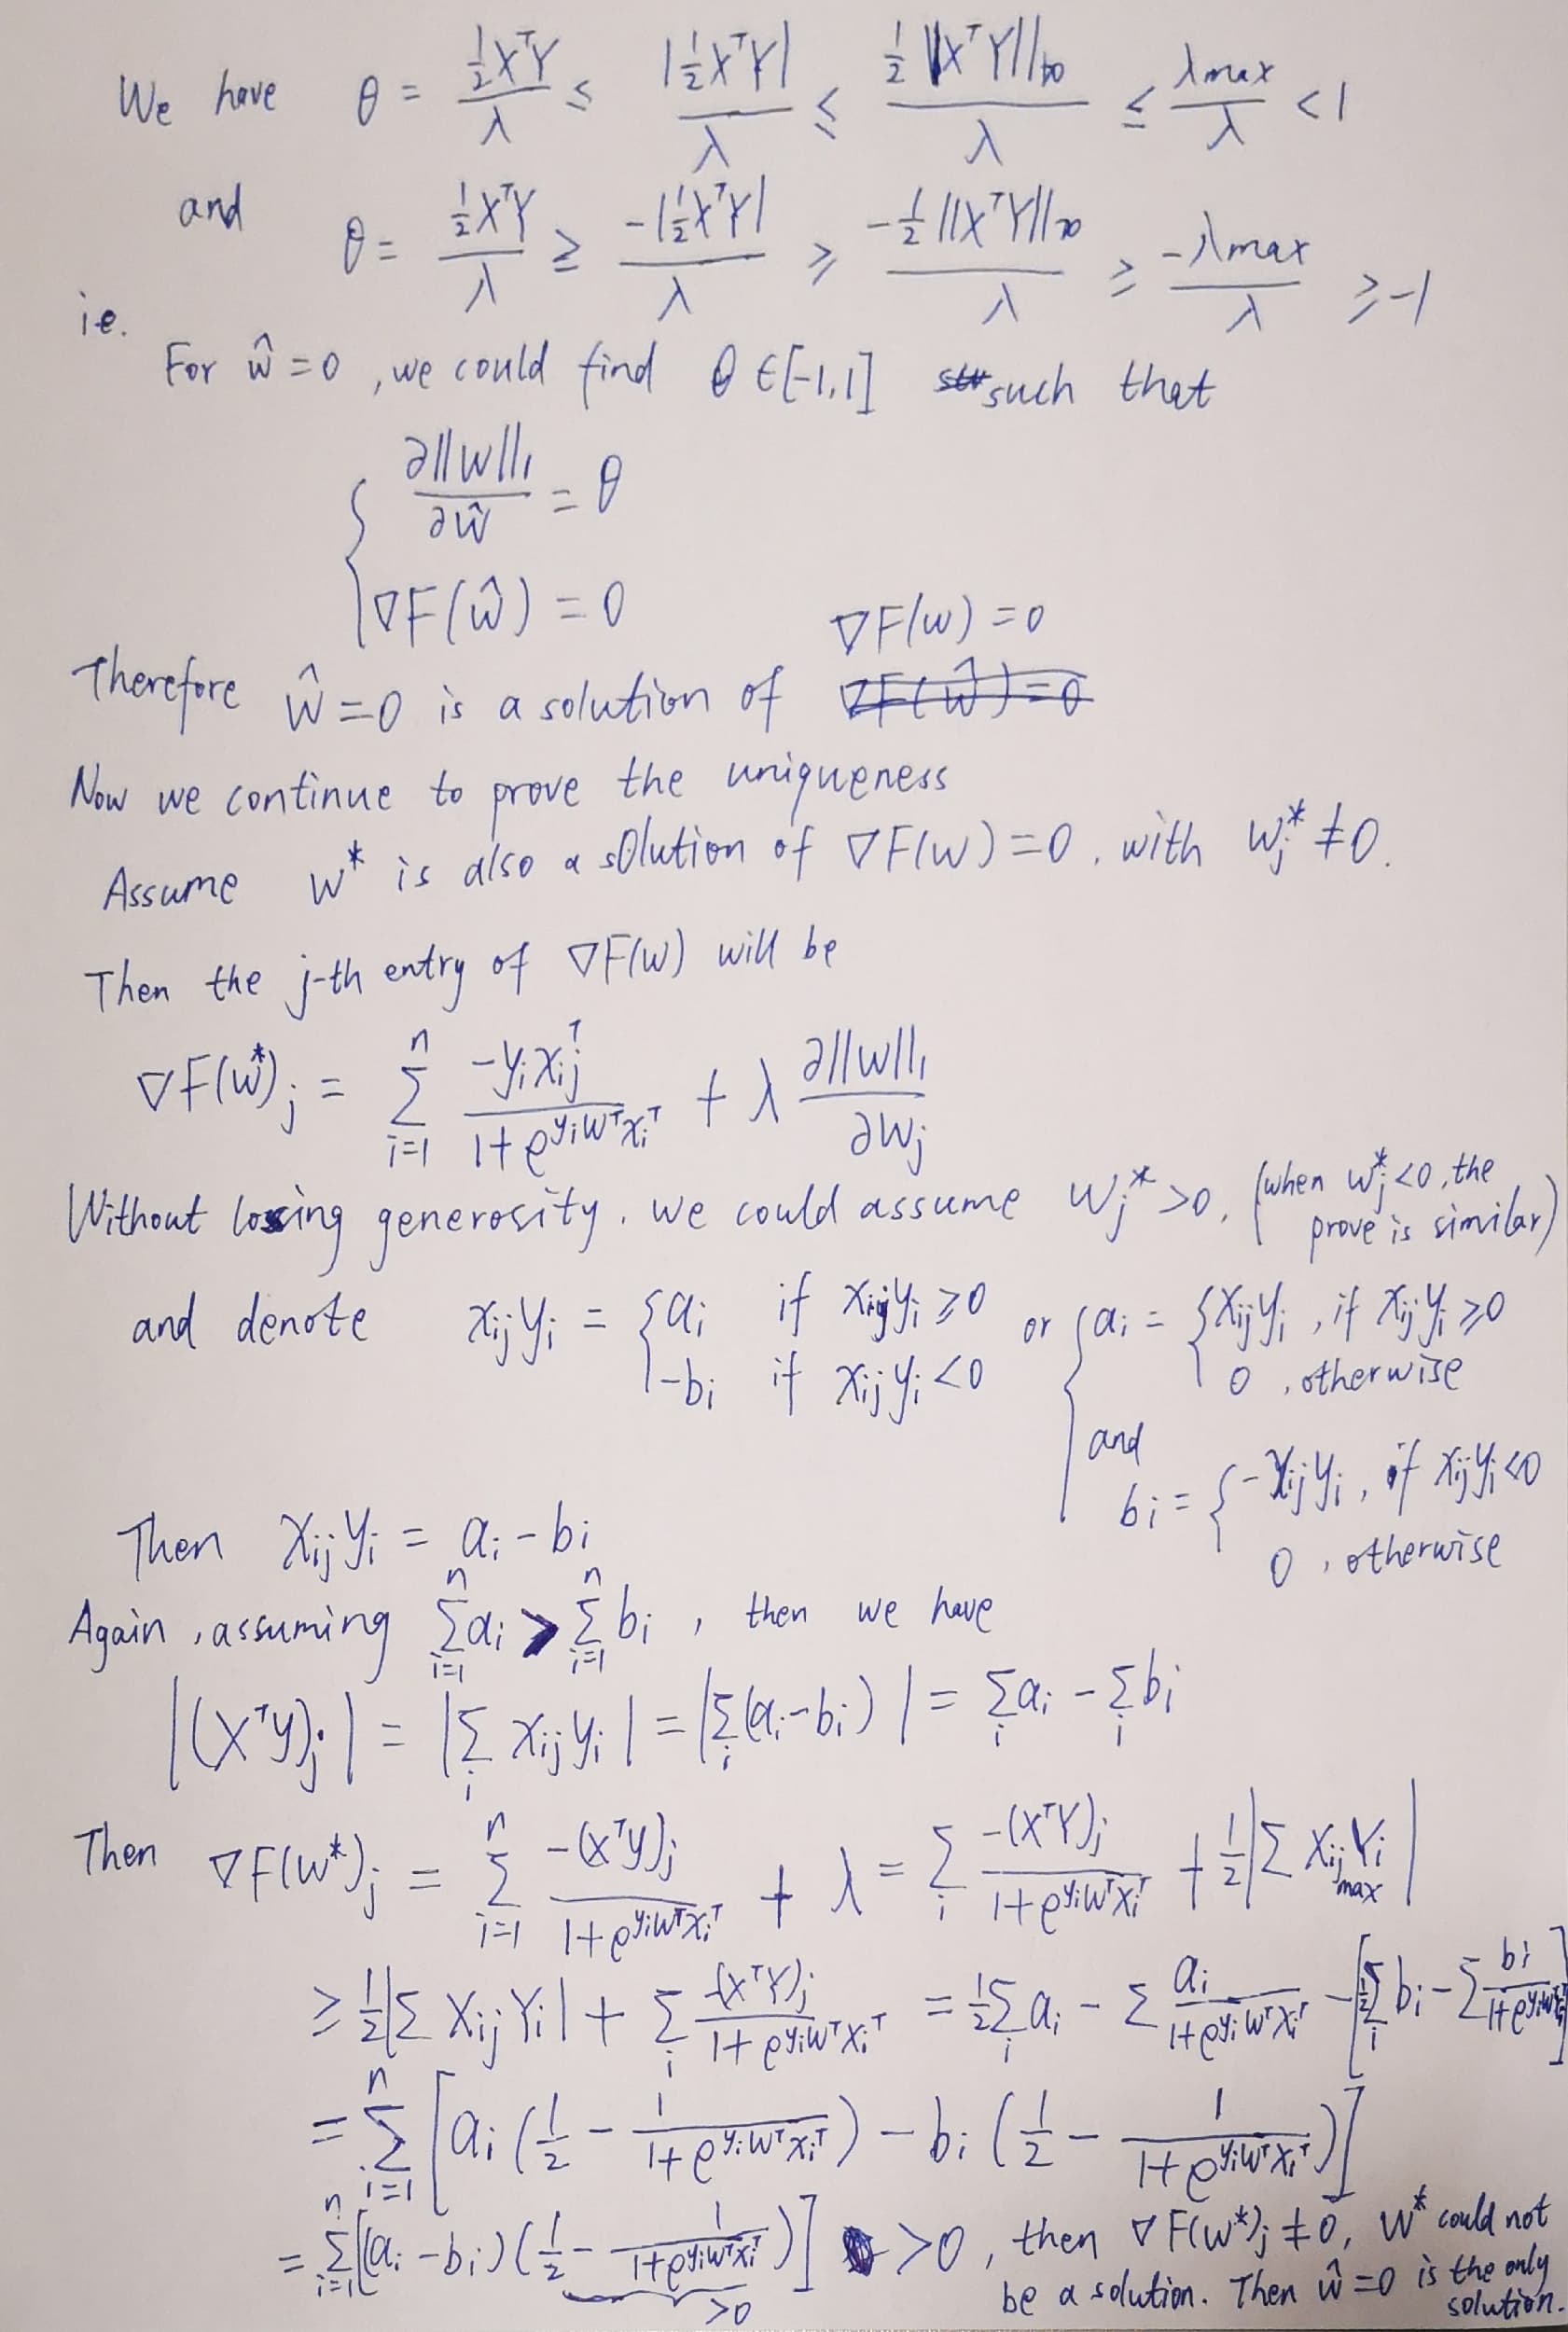

In [13]:
Image("page2.jpg")

2) Show that for sparse Logistic regression the coordinate-wise Lipschitz constant of the smooth term, $\gamma_j$, can be taken equal to $\Vert X_j \Vert^2 / 4$, where $X_j$ denotes the $j$-th column of $X$.

$g_j,_w(h) = f(w + e_jh) $, $f$ the function to minimize


So $$\nabla^2 g_j,_w(h) = e_t^j \nabla^2 f(w + e_jh)e_j =
e_t^j \sum_{i=1}^{n} y_i^2 X_iX_i^T \frac{\mathrm{e}^{y_i(w+e_jh)^TX_i}}{(1 + \mathrm{e}^{y_i(w+e_jh)^TX_i})^2} e_j $$

$ y \in [-1;1]$

$$ = e_t^j \sum_{i=1}^{n} X_iX_i^T \frac{\mathrm{e}^{y_i(w+e_jh)^TX_i}}{(1 + \mathrm{e}^{y_i(w+e_jh)^TX_i})^2} e_j $$

$ \frac{e^x}{(1+e^x)^2} \leq \frac{1}{4} $, $ x \in \mathbb{R} $

$$\nabla^2 g_j,_w(h) \leq e_t^j \sum_{i=1}^{n} X_iX_i^T  \frac{1}{4} e_j \leq e_t^j \sum_{i=1}^{n} \frac{\Vert X_i^Te_j\Vert}{4} e_j$$

We have $L_j = L(\nabla g_j,_w)$

So $ \gamma_j $ can be taken equal to $\frac{\Vert X_j \Vert^2}{4}$

You are now ready to code cyclic proximal coordinate descent for sparse Logistic regression:

**Bonus**: show that is possible, when the current iterate is w, to use the better Lipschitz constant 
    $$\sum_i  \frac{X_{i, j}^2}{(1 + \mathrm{e}^{-y_i X_{i, j} w_j)^2}}$$
    
*Anwswer*: Becase the updated $w_j$ information is included in each step and therefore the lipschitz constant is more precize and the step size will be adaptive compared to the case $\Vert X_j \Vert^2 / 4$

Implement it in the code with a `better_lc` parameter, and compare.

In [23]:
X, y = simu(coefs, n_samples=1000, for_logreg=True)
lambda_max = norm(X.T.dot(y), ord= np.inf) / 2.
lamb = lambda_max / 10.  
# much easier to parametrize lambda as a function of lambda_max than 
# to take random values like 0.1 in previous Labs


def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))


def soft_thresh(x, u):
    """Soft thresholding of x at level u"""
    return np.maximum(0., np.abs(x) - u)


def cd_logreg(X, y, lamb, n_iter,  lipid=1):
    # lipid to idicate which lipschizt constant to be choose: 
    #     lipid == 1: lipschitz constant:   ∥Xj∥^2 / 4 
    #     lipid == 1: lipschitz constant:   better_lc
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    Xw = X.dot(w)
    all_objs = np.zeros((n_iter, 1))
    
    # TODO
    lips_const = np.linalg.norm(X, axis = 0) ** 2 / 4
    # END TODO
    
    for t in range(n_iter):
        for j in range(n_features):
            old_w_j = w[j]
            # TODO
            
            if lipid == 1: 
                step = 1 /  lips_const[j] 
            elif lipid == 2:  # better_lc 
                lips_const_j = np.sum(Xj * 2 * sigmoid(y * Xj * old_w_j) * 2)     
                step  = 1 / lips_const_j

            grad_j =  - np.sum(y * X[:, j] * sigmoid(-y * Xw))
            diff_w_j = old_w_j - step * grad_j
            
            w[j] =  np.sign(diff_w_j) * soft_thresh(diff_w_j, lamb * step)
            
            if old_w_j != w[j]:
                Xw += X[:, j] * (w[j] - old_w_j)
            #END TODO
            
        all_objs[t] = np.log(1. + np.exp(-y * Xw)).sum() + lamb * norm(w, ord=1)
    
    return w, all_objs

###   Compare lipid = 1 ( $\Vert X_j \Vert^2 / 4$) and lipid = 2 ($\sum_i  \frac{X_{i, j}^2}{(1 + \mathrm{e}^{-y_i X_{i, j}w_j)^2}}$)
We run some test with the simulated data for logistic regression from assignment 1 for the case of 
lipid = 1 ( $\Vert X_j \Vert^2 / 4$) and lipid = 2 ($\sum_i  \frac{X_{i, j}^2}{(1 + \mathrm{e}^{-y_i X_{i, j} w_j)^2}}$). The case of lipid = 2 (better Lipschitz constant) performs better as the step size gradually declines and we could reach a more accurate result with lesser errors. With lipid = 2 (better Lipschitz constant), the model then becomes an adaptive step-size model, while with  lipid = 1 ( $\Vert X_j \Vert^2 / 4$) , the Lipschitz constant is really constant and so is the step size.

# Part 3: Real data

We will compare vanilla cyclic CD and ISTA to solve the Lasso on a real dataset, called _leukemia_.

You can download the file here: http://web.stanford.edu/~hastie/CASI_files/DATA/leukemia_big.csv, and you should place it in the same folder as the current notebook.

In [15]:
from numpy import genfromtxt
y = 2 * (genfromtxt('leukemia_big.csv', delimiter=',', dtype=str)[0] == 'ALL') - 1
X = genfromtxt('leukemia_big.csv', delimiter=',')[1:].T

print(X.shape)
print(y.shape)

(72, 7128)
(72,)


In [16]:
lambda_max_lasso = norm(X.T.dot(y), ord=np.inf)
lambd = lambda_max_lasso / 5.

Code:
- a simple proximal gradient solver for the Lasso
- a prox CD solver for the Lasso
and compare them on this dataset. 
Do the plots in terms of epochs, not updates (to be fair to CD).

In [17]:
def prox_lasso(w, s):
    """Proximal operator for the Lasso at x"""
    return np.sign(w) * (np.maximum(abs(w)-s,0))
    
def lasso(w, s):
    """Value of the Lasso penalization at x"""
    return s * norm(w, ord=1)

def grad_logreg(w):
    """Logistic gradient"""
    return np.sum(-y * X.T * sigmoid(-y * X.dot(w)), axis = 1)

def loss_logreg(w):
    """Logistic loss"""
    return (np.log(1 + np.exp(-y * X.dot(w)))).sum()

def lipschitz_logreg():
    return norm(X, ord=2) ** 2 / (4. * n_samples)

def ista(w_init, X, y, lambd, n_iter=50):
    """Proximal gradient descent algorithm
    """
    
    l = lipschitz_logreg()
    step = 1 / l
    
    w = w_init.copy()
    # objective history
    objectives = []
    # Current objective
    obj = loss_logreg(w) + lasso(w, lambd)
    objectives.append(obj)
        
    for k in range(n_iter + 1):
        
        w = prox_lasso(w - step * grad_logreg(w), lambd / l)
       
        obj = loss_logreg(w) + lasso(w, lambd)
        objectives.append(obj)

    return w, objectives

In [18]:
n_samples = X.shape[0]
n_features = X.shape[1]
w_init = np.zeros(n_features)

In [19]:
ref_w, ref_objectives = ista(w_init, X, y, lambd, 100)
print ('The precise minimum for ista is: ',  ref_objectives[-1])

The precise minimum for ista is:  40.03880561822489


In [20]:
w_init = np.zeros(n_features)
cd_w, cd_obj = cd_logreg(X, y, lambd, 100)
print ('The precise minimum for cd is: ',  cd_obj[-1])

The precise minimum for cd is:  [39.43876277]


In [21]:
f_min_ista = [norm(f - cd_obj[-1]) for f in ref_objectives]
f_min_cd = [norm(f - cd_obj[-1]) for f in cd_obj]

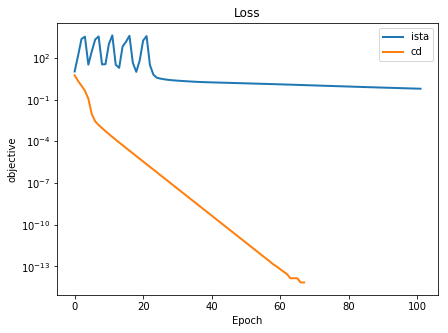

In [22]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.semilogy(f_min_ista, lw=2, label="ista")
plt.semilogy(f_min_cd, lw=2, label="cd")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("objective")
plt.legend(loc=1)
plt.show()

- We observe that the prox CD solver converges faster than the proximal gradient descent for the lasso.
- In this sparse data situation, CD wil update the parameters that really matters. Those non influential will be close to zero.
- For proximal GD, it will update all parameters at each iteration and that's why it is not as efficient as CD.

To conclude, we can say that coordinate descent behaves well in specific situations such as high dimensional problems with saprse data like the above one.